# Downloading Data

In [1]:
!mkdir /root/.kaggle

# Let's confirm that the directory is created
!cd /root/ && ls -la
# Move kaggle.json to .kaggle directory
!mv kaggle.json /root/.kaggle/kaggle.json

# Change file permission to allow python to access it
!chmod 600 /root/.kaggle/kaggle.json

# List files inside .kaggle to confirm that the file is moved
!cd /root/.kaggle && ls -la
!kaggle competitions download kkbox-music-recommendation-challenge


total 64
drwx------ 1 root root 4096 Nov 20 08:55 .
drwxr-xr-x 1 root root 4096 Nov 20 08:42 ..
-r-xr-xr-x 1 root root 1169 Jan  1  2000 .bashrc
drwxr-xr-x 1 root root 4096 Nov 17 14:45 .cache
drwx------ 4 root root 4096 Nov 17 14:44 .config
drwxr-xr-x 5 root root 4096 Nov 17 14:44 .ipython
drwx------ 2 root root 4096 Nov 17 14:44 .jupyter
drwxr-xr-x 2 root root 4096 Nov 20 08:55 .kaggle
drwxr-xr-x 2 root root 4096 Nov 17 14:42 .keras
drwxr-xr-x 1 root root 4096 Nov 17 14:44 .local
drwxr-xr-x 4 root root 4096 Nov 17 14:44 .npm
-rw-r--r-- 1 root root  148 Aug 17  2015 .profile
-r-xr-xr-x 1 root root  254 Jan  1  2000 .tmux.conf
-rw-r--r-- 1 root root  165 Nov 17 14:44 .wget-hsts
total 16
drwxr-xr-x 2 root root 4096 Nov 20 08:55 .
drwx------ 1 root root 4096 Nov 20 08:55 ..
-rw------- 1 root root   69 Nov 20 08:55 kaggle.json
 95% 329M/345M [00:01<00:00, 173MB/s]
100% 345M/345M [00:01<00:00, 189MB/s]


In [2]:
!unzip /content/kkbox-music-recommendation-challenge
!7z e train.csv.7z
!7z e members.csv.7z
!7z e songs.csv.7z
!7z e sample_submission.csv.7z 
!7z e song_extra_info.csv.7z
!7z e test.csv.7z

Archive:  /content/kkbox-music-recommendation-challenge.zip
  inflating: members.csv.7z          
  inflating: sample_submission.csv.7z  
  inflating: song_extra_info.csv.7z  
  inflating: songs.csv.7z            
  inflating: test.csv.7z             
  inflating: train.csv.7z            

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 106420688 bytes (102 MiB)

Extracting archive: train.csv.7z
--
Path = train.csv.7z
Type = 7z
Physical Size = 106420688
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      2% - train.csv                  5% - train.csv                  7% - train.csv                 10% - train.csv                

# Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve,roc_auc_score,classification_report,roc_curve,accuracy_score,confusion_matrix
from tqdm import tqdm
from subprocess import check_output
import matplotlib.pyplot as plt
import seaborn as sns 

# Read data

In [45]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
songs = pd.read_csv('songs.csv')
members = pd.read_csv('members.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [4]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [5]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [6]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [7]:
sample.head()

,id,target
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [8]:
train.info()
print("\n")
songs.info()
print("\n")
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   msno                object
 1   song_id             object
 2   source_system_tab   object
 3   source_screen_name  object
 4   source_type         object
 5   target              int64 
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   song_id      object 
 1   song_length  int64  
 2   genre_ids    object 
 3   artist_name  object 
 4   composer     object 
 5   lyricist     object 
 6   language     float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  -

# Visualization

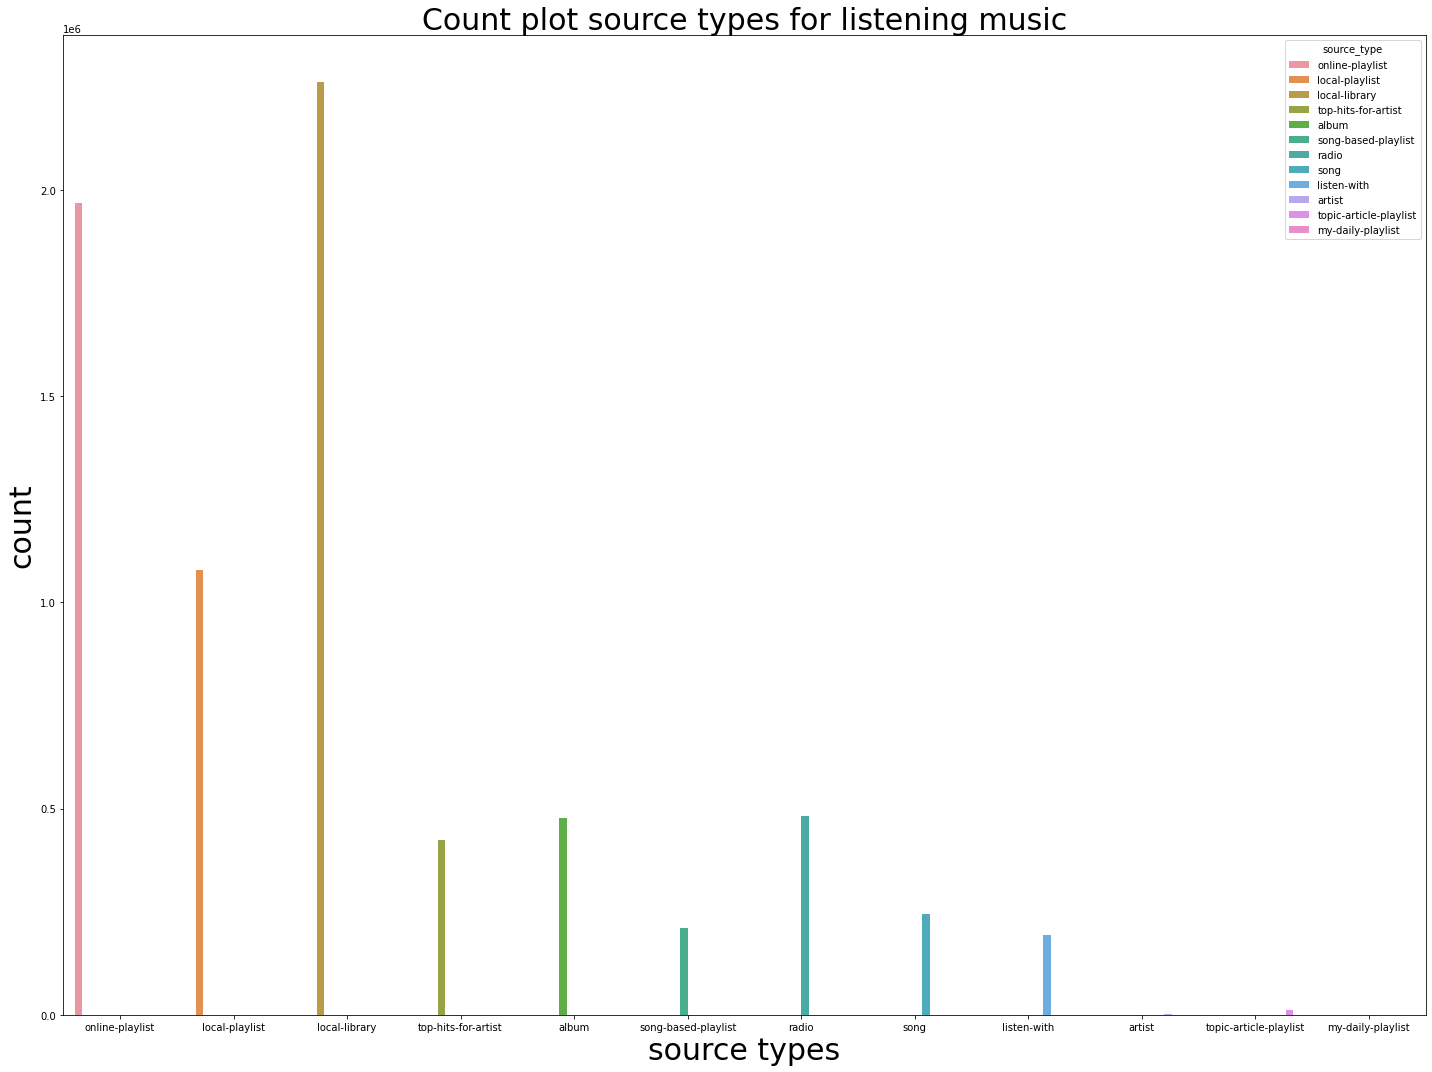

In [9]:
plt.figure(figsize=(20,15))
sns.countplot(x='source_type',hue='source_type',data=train)
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.title('Count plot source types for listening music',fontsize=30)
plt.tight_layout()

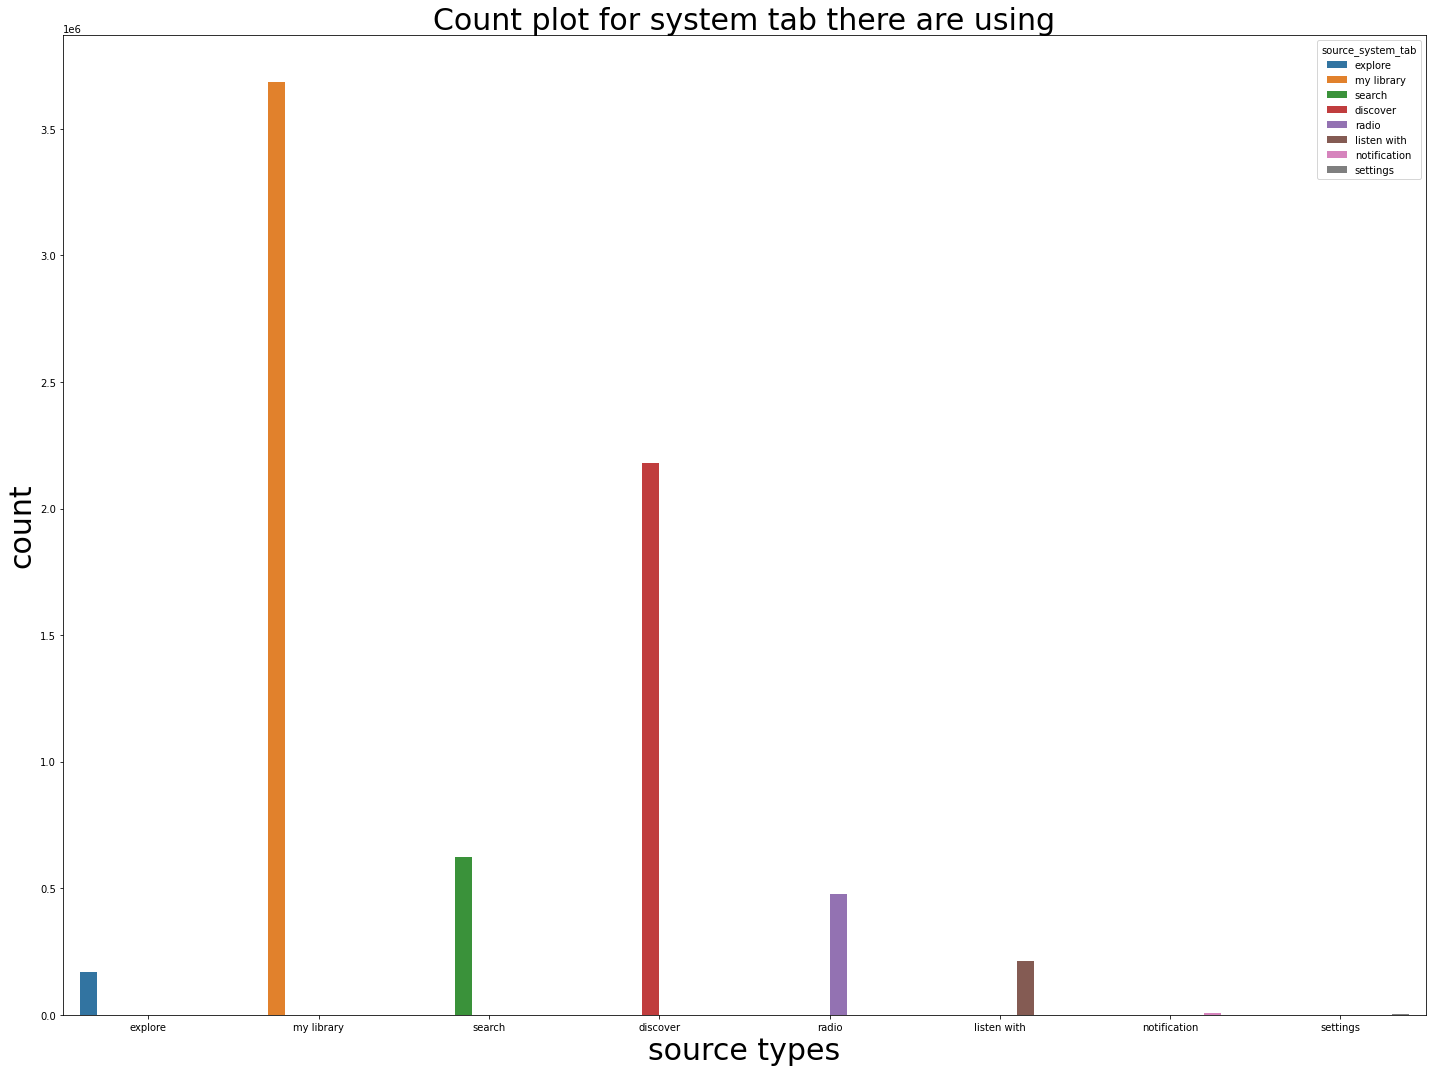

In [10]:
plt.figure(figsize=(20,15))
sns.countplot(x='source_system_tab',hue='source_system_tab',data=train)
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.title('Count plot for system tab there are using',fontsize=30)
plt.tight_layout()

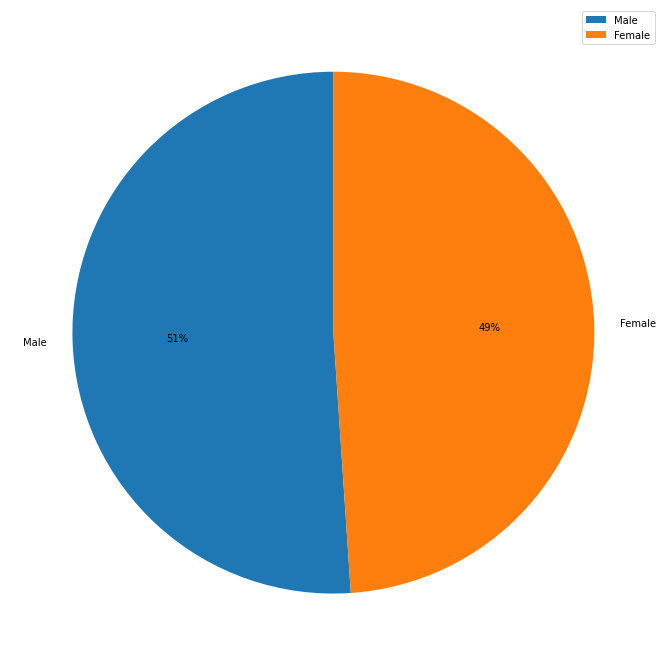

In [11]:
labels = ['Male','Female']
plt.figure(figsize = (12, 12))
sizes = pd.value_counts(members.gender)
patches, texts, autotexts = plt.pie(sizes, 
                                    labels=labels, autopct='%.0f%%',
                                    shadow=False, radius=1,startangle=90)
plt.legend()
plt.show()

In [12]:
members.describe()

,city,bd,registered_via,registration_init_time,expiration_date
count,34403.000000,34403.000000,34403.000000,3.440300e+04,3.440300e+04
mean,5.371276,12.280935,5.953376,2.013994e+07,2.016901e+07
std,6.243929,18.170251,2.287534,2.954015e+04,7.320925e+03
min,1.000000,-43.000000,3.000000,2.004033e+07,1.970010e+07
25%,1.000000,0.000000,4.000000,2.012103e+07,2.017020e+07
50%,1.000000,0.000000,7.000000,2.015090e+07,2.017091e+07
75%,10.000000,25.000000,9.000000,2.016110e+07,2.017093e+07
max,22.000000,1051.000000,16.000000,2.017023e+07,2.020102e+07


In [13]:
songs.describe()

,song_length,language
count,2.296320e+06,2.296319e+06
mean,2.469935e+05,3.237800e+01
std,1.609200e+05,2.433241e+01
min,1.850000e+02,-1.000000e+00
25%,1.836000e+05,-1.000000e+00
50%,2.266270e+05,5.200000e+01
75%,2.772690e+05,5.200000e+01
max,1.217385e+07,5.900000e+01


In [14]:
train.describe()

,target
count,7.377418e+06
mean,5.035171e-01
std,4.999877e-01
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


In [15]:
train_members = pd.merge(train, members, on='msno', how='inner')
train_merged = pd.merge(train_members, songs, on='song_id', how='outer')
print(train_merged.head())

                                           msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=   
2  xbodnNBaLMyqqI7uFJlvHOKMJaizuWo/BB/YHZICcKo=   
3  s0ndDsjI79amU0RBiullFN8HRz9HjE++34jGNa7zJ/s=   
4  Vw4Umh6/qlsJDC/XMslyAxVvRgFJGHr53yb/nrmY1DU=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=          discover   
2  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=        my library   
3  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=        my library   
4  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=        my library   

     source_screen_name      source_type  target  city    bd  gender  \
0               Explore  online-playlist     1.0   1.0   0.0     NaN   
1  Online playlist more  online-playlist     0.0  15.0  18.0    male   
2   Local playlist more    local-library     1.0   1.0   0.0  

In [16]:
test_members = pd.merge(test, members, on='msno', how='inner')
test_merged = pd.merge(test_members, songs, on='song_id', how='outer')
print(test_merged.head())
print(len(test_merged.columns))

          id                                          msno  \
0        0.0  V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=   
1  1035059.0  08rvvaaab7dM7h78GC4SphLkUCSXPxpu6sY+k8aLUO4=   
2    89968.0  1NvrMNDUcvfqOIjhim8BgdK23znMzGwAO84W+qKs6dw=   
3   972394.0  GfSXhTVP3oj7h0545L/5xh6jD+7edQ7AH0iprl7dYbc=   
4  2194574.0  HkWEvfQyrb5Lve8X3B7HkCEkDFW8qFy/9kWFb4QbM5k=   

                                        song_id source_system_tab  \
0  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
1  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
2  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
3  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
4  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=          discover   

    source_screen_name          source_type  city    bd  gender  \
0  Local playlist more        local-library   1.0   0.0     NaN   
1  Local playlist more        local-library   5.0  29.0  female   
2  Local pl

In [17]:
del train_members
del test_members

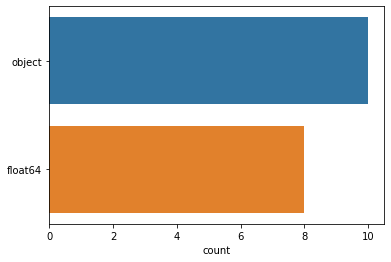

In [18]:
ax = sns.countplot(y=train_merged.dtypes, data=train_merged)

In [19]:
def check_missing_values(df):
    print (df.isnull().values.any())
    if (df.isnull().values.any() == True):
        columns_with_Nan = df.columns[df.isnull().any()].tolist()
    print(columns_with_Nan)
    for col in columns_with_Nan:
        print("%s : %d" % (col, df[col].isnull().sum()))
    
check_missing_values(train_merged)
check_missing_values(test_merged)

True
['msno', 'source_system_tab', 'source_screen_name', 'source_type', 'target', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
msno : 1936406
source_system_tab : 1961255
source_screen_name : 2351210
source_type : 1957945
target : 1936406
city : 1936406
bd : 1936406
gender : 4897885
registered_via : 1936406
registration_init_time : 1936406
expiration_date : 1936406
song_length : 114
genre_ids : 205338
artist_name : 114
composer : 2591558
lyricist : 4855358
language : 150
True
['id', 'msno', 'source_system_tab', 'source_screen_name', 'source_type', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
id : 2071581
msno : 2071581
source_system_tab : 2080023
source_screen_name : 2234464
source_type : 2078878
city : 2071581
bd : 2071581
gender : 3123805
register

In [20]:
def replace_Nan_non_object(df):
    object_cols = list(df.select_dtypes(include=['float']).columns)
    for col in object_cols:
        df[col]=df[col].fillna(int(-5))
       
replace_Nan_non_object(train_merged) 
replace_Nan_non_object(test_merged)  

In [21]:
mem = train_merged.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))
mem = test_merged.memory_usage(index=True).sum()
print("Memory consumed by test set      :   {} MB" .format(mem/ 1024**2))

Memory consumed by training set  :   1350.117919921875 MB
Memory consumed by test set      :   670.9216995239258 MB


In [22]:
def change_datatype(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

change_datatype(train_merged)
change_datatype(test_merged)

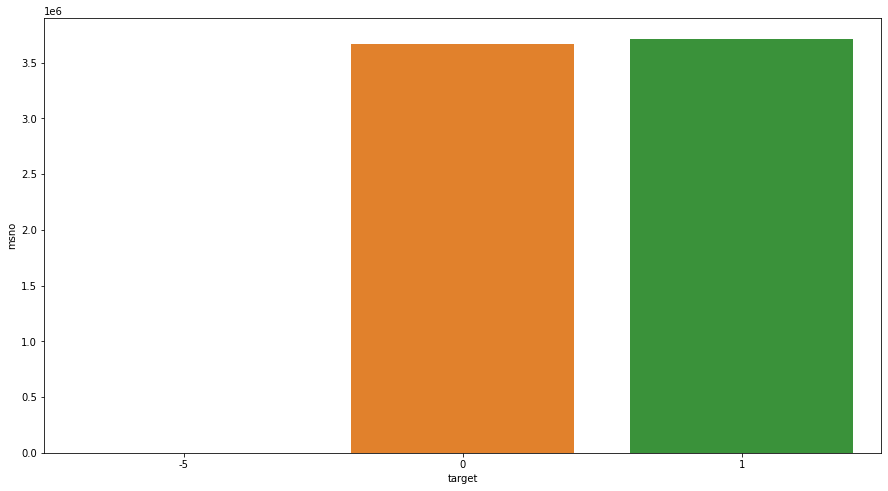

In [23]:
data = train_merged.groupby('target').aggregate({'msno':'count'}).reset_index()
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(x='target', y='msno', data=data)

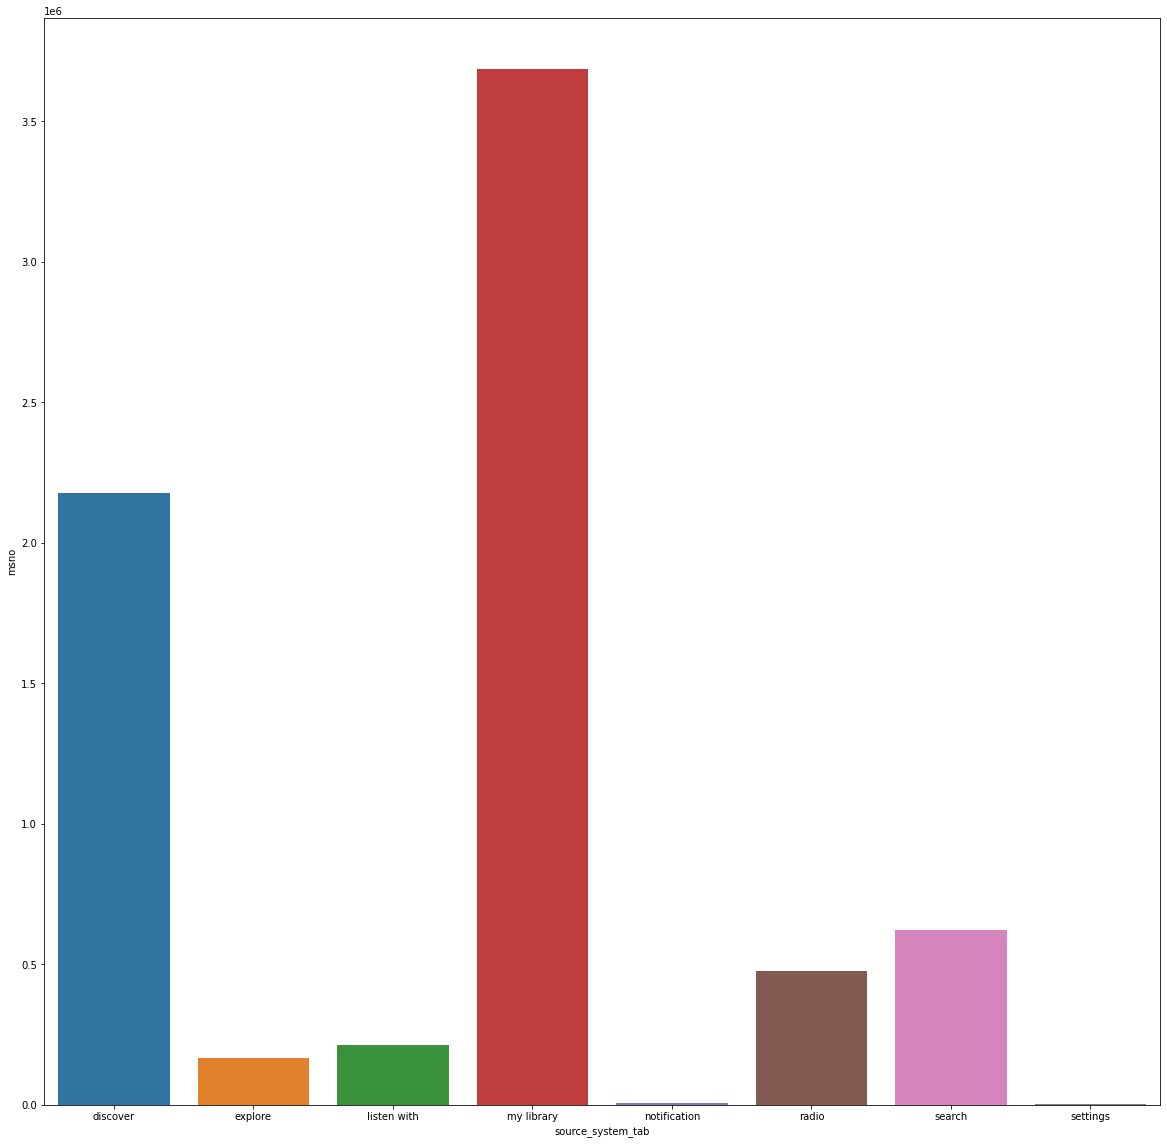

In [24]:
plt.figure(figsize = (20, 20)) 
data=train_merged.groupby('source_system_tab').aggregate({'msno':'count'}).reset_index()
sns.barplot(x='source_system_tab',y='msno',data=data)

[Text(0, 0, 'Album more'),
 Text(0, 0, 'Artist more'),
 Text(0, 0, 'Concert'),
 Text(0, 0, 'Discover Chart'),
 Text(0, 0, 'Discover Feature'),
 Text(0, 0, 'Discover Genre'),
 Text(0, 0, 'Discover New'),
 Text(0, 0, 'Explore'),
 Text(0, 0, 'Local playlist more'),
 Text(0, 0, 'My library'),
 Text(0, 0, 'My library_Search'),
 Text(0, 0, 'Online playlist more'),
 Text(0, 0, 'Others profile more'),
 Text(0, 0, 'Payment'),
 Text(0, 0, 'Radio'),
 Text(0, 0, 'Search'),
 Text(0, 0, 'Search Home'),
 Text(0, 0, 'Search Trends'),
 Text(0, 0, 'Self profile more'),
 Text(0, 0, 'Unknown')]

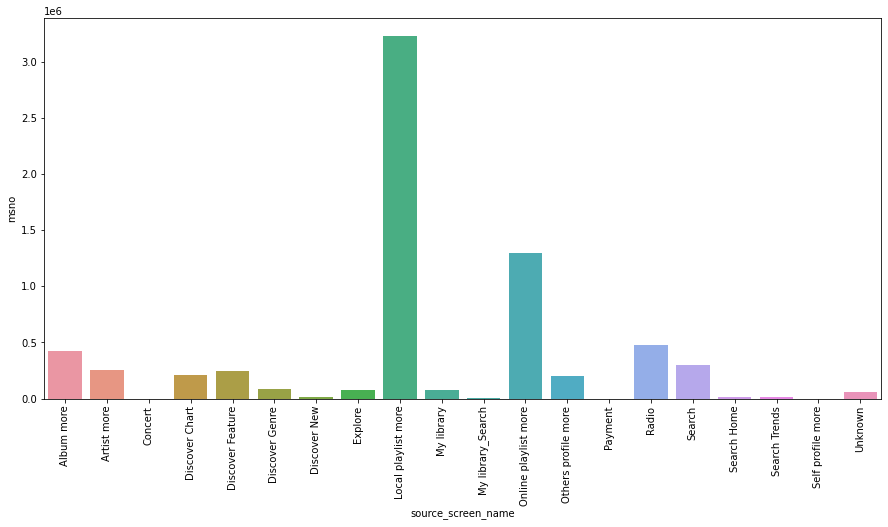

In [25]:
data = train_merged.groupby('source_screen_name').aggregate({'msno':'count'}).reset_index()
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.barplot(x='source_screen_name', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, 'album'),
 Text(0, 0, 'artist'),
 Text(0, 0, 'listen-with'),
 Text(0, 0, 'local-library'),
 Text(0, 0, 'local-playlist'),
 Text(0, 0, 'my-daily-playlist'),
 Text(0, 0, 'online-playlist'),
 Text(0, 0, 'radio'),
 Text(0, 0, 'song'),
 Text(0, 0, 'song-based-playlist'),
 Text(0, 0, 'top-hits-for-artist'),
 Text(0, 0, 'topic-article-playlist')]

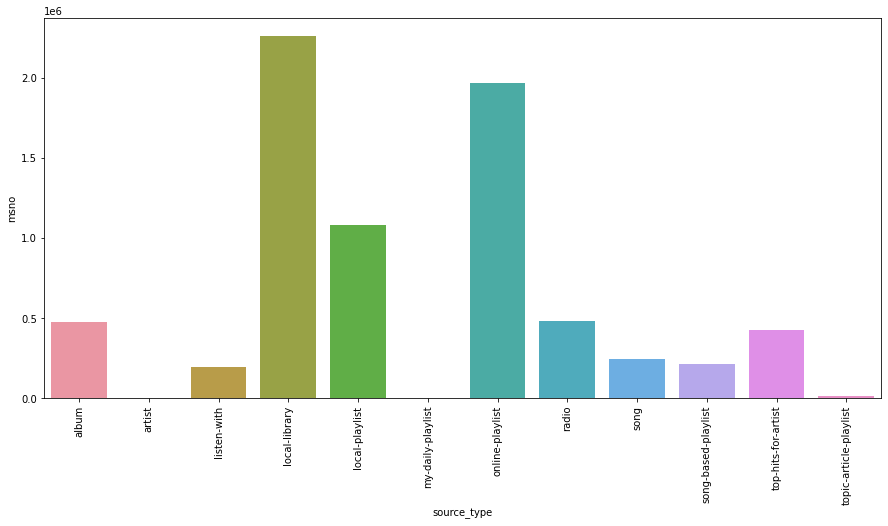

In [26]:
data = train_merged.groupby('source_type').aggregate({'msno':'count'}).reset_index()
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.barplot(x='source_type', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '-5'),
 Text(0, 0, '-1'),
 Text(0, 0, '3'),
 Text(0, 0, '10'),
 Text(0, 0, '17'),
 Text(0, 0, '24'),
 Text(0, 0, '31'),
 Text(0, 0, '38'),
 Text(0, 0, '45'),
 Text(0, 0, '52'),
 Text(0, 0, '59')]

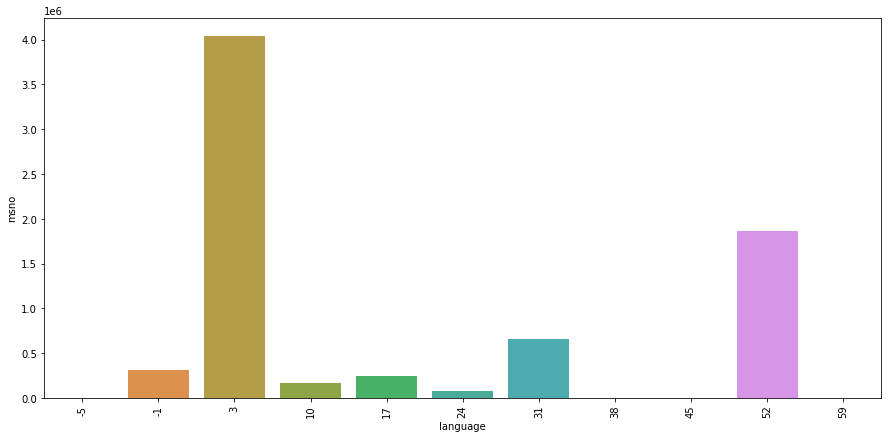

In [27]:
data = train_merged.groupby('language').aggregate({'msno':'count'}).reset_index()
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.barplot(x='language', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '-5'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '7'),
 Text(0, 0, '9'),
 Text(0, 0, '13')]

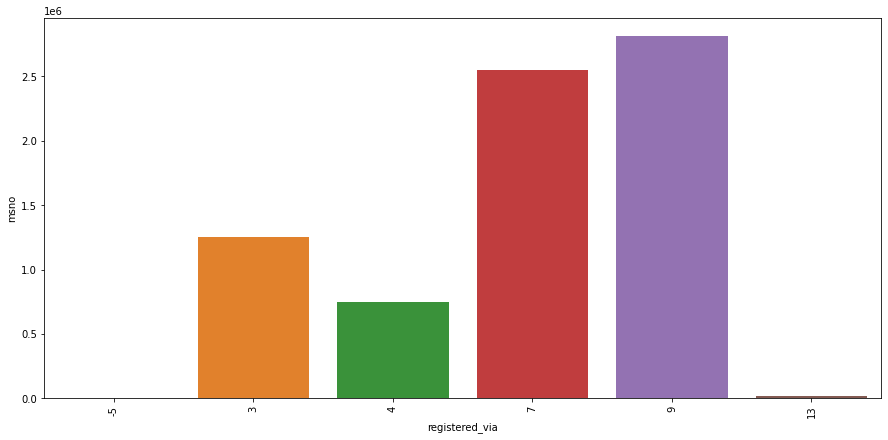

In [28]:
data = train_merged.groupby('registered_via').aggregate({'msno':'count'}).reset_index()
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.barplot(x='registered_via', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '-5'),
 Text(0, 0, '1'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '19'),
 Text(0, 0, '20'),
 Text(0, 0, '21'),
 Text(0, 0, '22')]

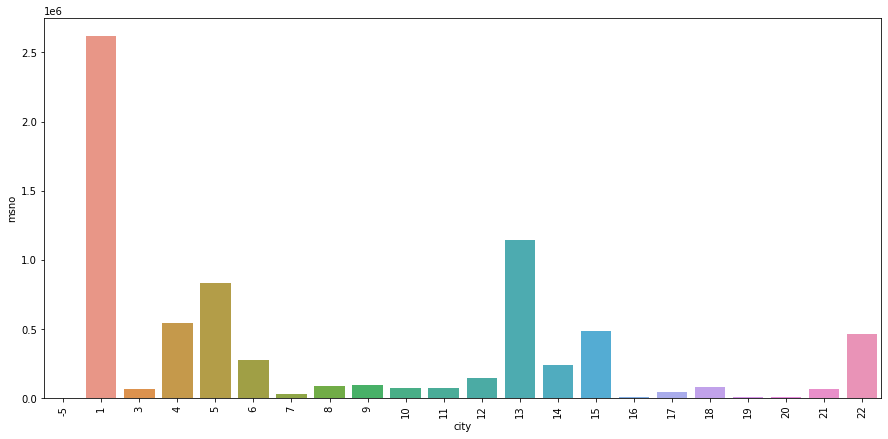

In [29]:
data = train_merged.groupby('city').aggregate({'msno':'count'}).reset_index()
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.barplot(x='city', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

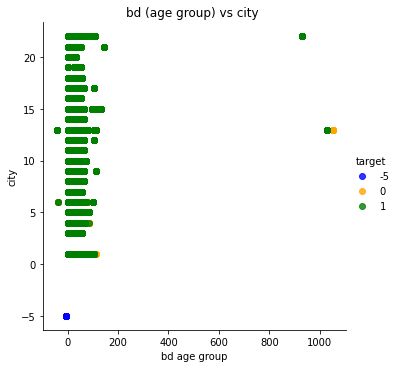

In [30]:
ax=sns.lmplot(x="bd",y="city",data=train_merged,palette=['blue','orange','green'],hue="target",fit_reg=False)
plt.xlabel("bd age group")
plt.ylabel("city")
plt.title("bd (age group) vs city ")
plt.show()

In [31]:
train_merged.describe()
def remove_outlier(df_in, col_name):
    fence_low  = 12
    fence_high = 45
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out
df_final_train=remove_outlier(train_merged,'bd')

In [32]:
df_final_train

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
1,pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Online playlist more,online-playlist,0,15,18,male,4,20151220,20170930,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52
3,s0ndDsjI79amU0RBiullFN8HRz9HjE++34jGNa7zJ/s=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,1,5,21,female,9,20110808,20170917,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52
4,Vw4Umh6/qlsJDC/XMslyAxVvRgFJGHr53yb/nrmY1DU=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,0,6,33,female,9,20070323,20170915,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52
5,YqtKhiDOFJ/gdd2V4AFdnVwGMMaA0yUEbb8w7xuoP7I=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Discover Chart,online-playlist,0,5,23,female,9,20141223,20171012,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52
6,jGiECz8y+oKS0tDcZArJXK2ZQisBpk/OC3wh4kvs8gc=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Online playlist more,song-based-playlist,1,5,27,female,9,20140424,20180207,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377344,c7uwxR/Iz0Mk/3fj9bzhJYrhKp+ziWDlXohxZvygxgA=,evmSwe8m+/VCS4eljfK+jJcvY20BqNtG3+GzV4Id4Y8=,search,Album more,album,1,22,20,male,3,20140830,20171003,295079,451,Mr.,Alan Po,NaN,24
7377345,c7uwxR/Iz0Mk/3fj9bzhJYrhKp+ziWDlXohxZvygxgA=,5pHrRxM0k09O1thXaU8tOa7nAQcHpe3559RTtZBPip4=,search,Album more,album,1,22,20,male,3,20140830,20171003,205914,451,Mr.,Alan Po,NaN,24
7377348,/xjMtlYh6YSvPV4XTV+/sp44EHS8FJFzZMGQHQU5dks=,5VVP70wfwbaCtp3jPrkpXEdRIdXnFjiIlWQ4BUxhqzA=,search,Album more,album,0,22,18,male,3,20130611,20170707,217710,465,Tokio Hotel,NaN,NaN,52
7377413,QPrVEVrWZBD2+QNPnzxHWAUUHd2IpicbPcd99Eqf7LY=,l8lKnHq4b696qArQcMLE7yK8E7Nf6WdLU3s/mvT8BYQ=,search,Search,song,1,5,31,male,9,20110506,20171003,254537,458,Various Artists,丁延哲,丁延哲,3


In [33]:
df_final_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4150113 entries, 1 to 7377415
Data columns (total 18 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   msno                    object
 1   song_id                 object
 2   source_system_tab       object
 3   source_screen_name      object
 4   source_type             object
 5   target                  int8  
 6   city                    int8  
 7   bd                      int16 
 8   gender                  object
 9   registered_via          int8  
 10  registration_init_time  int32 
 11  expiration_date         int32 
 12  song_length             int32 
 13  genre_ids               object
 14  artist_name             object
 15  composer                object
 16  lyricist                object
 17  language                int8  
dtypes: int16(1), int32(3), int8(4), object(10)
memory usage: 419.5+ MB


In [34]:
for col in df_final_train.select_dtypes(include=['object']).columns:
    df_final_train[col] = df_final_train[col].astype('category')
for col in df_final_train.select_dtypes(include=['category']).columns:
    df_final_train[col] = df_final_train[col].cat.codes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [35]:
df_final_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4150113 entries, 1 to 7377415
Data columns (total 18 columns):
 #   Column                  Dtype
---  ------                  -----
 0   msno                    int16
 1   song_id                 int32
 2   source_system_tab       int8 
 3   source_screen_name      int8 
 4   source_type             int8 
 5   target                  int8 
 6   city                    int8 
 7   bd                      int16
 8   gender                  int8 
 9   registered_via          int8 
 10  registration_init_time  int32
 11  expiration_date         int32
 12  song_length             int32
 13  genre_ids               int16
 14  artist_name             int16
 15  composer                int32
 16  lyricist                int16
 17  language                int8 
dtypes: int16(5), int32(5), int8(8)
memory usage: 182.1 MB


In [36]:
target = df_final_train.pop('target')

In [37]:
train_data, test_data, train_labels, test_labels = train_test_split( df_final_train , target, test_size = 0.25)

In [38]:
from sklearn.tree import DecisionTreeClassifier
classifier=DecisionTreeClassifier(random_state=0)
classifier.fit(train_data,train_labels)

DecisionTreeClassifier(random_state=0)

In [42]:
y_pred=classifier.predict(test_data)

In [43]:
accuracy_score(test_labels,y_pred)

0.6433593663406035